In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import db.Db as db

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

np.random.seed(0)

In [2]:
result, column_name = db.getWeather()
data = pd.DataFrame(data=result, columns=column_name)
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NA,NA,W,44,W,...,71,22,1007.7,1007.1,8,NA,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NA,NA,WNW,44,NNW,...,44,25,1010.6,1007.8,NA,NA,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NA,NA,WSW,46,W,...,38,30,1007.6,1008.7,NA,2,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NA,NA,NE,24,SE,...,45,16,1017.6,1012.8,NA,NA,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NA,NA,W,41,ENE,...,82,33,1010.8,1006.0,7,8,17.8,29.7,No,No


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119590 entries, 0 to 119589
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           119590 non-null  object 
 1   Location       119590 non-null  object 
 2   MinTemp        119590 non-null  float64
 3   MaxTemp        119590 non-null  float64
 4   Rainfall       119590 non-null  float64
 5   Evaporation    119590 non-null  object 
 6   Sunshine       119590 non-null  object 
 7   WindGustDir    119590 non-null  object 
 8   WindGustSpeed  119590 non-null  int64  
 9   WindDir9am     119590 non-null  object 
 10  WindDir3pm     119590 non-null  object 
 11  WindSpeed9am   119590 non-null  int64  
 12  WindSpeed3pm   119590 non-null  int64  
 13  Humidity9am    119590 non-null  int64  
 14  Humidity3pm    119590 non-null  int64  
 15  Pressure9am    119590 non-null  float64
 16  Pressure3pm    119590 non-null  float64
 17  Cloud9am       119590 non-nul

<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

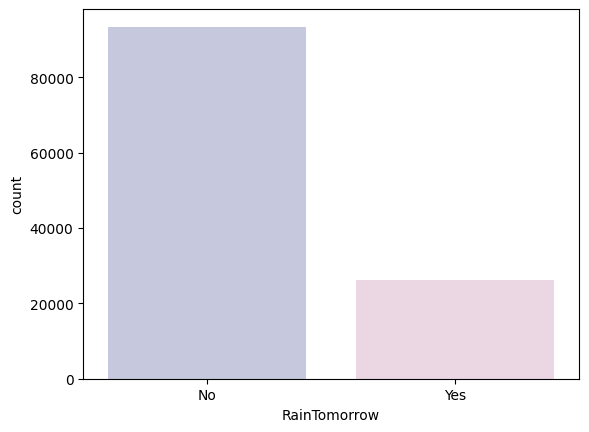

In [4]:
#first of all let us evaluate the target and find out if our data is imbalanced or not
cols = ["#C2C4E2", "#EED4E5"]
sns.countplot(x=data["RainTomorrow"], palette=cols)

<AxesSubplot:>

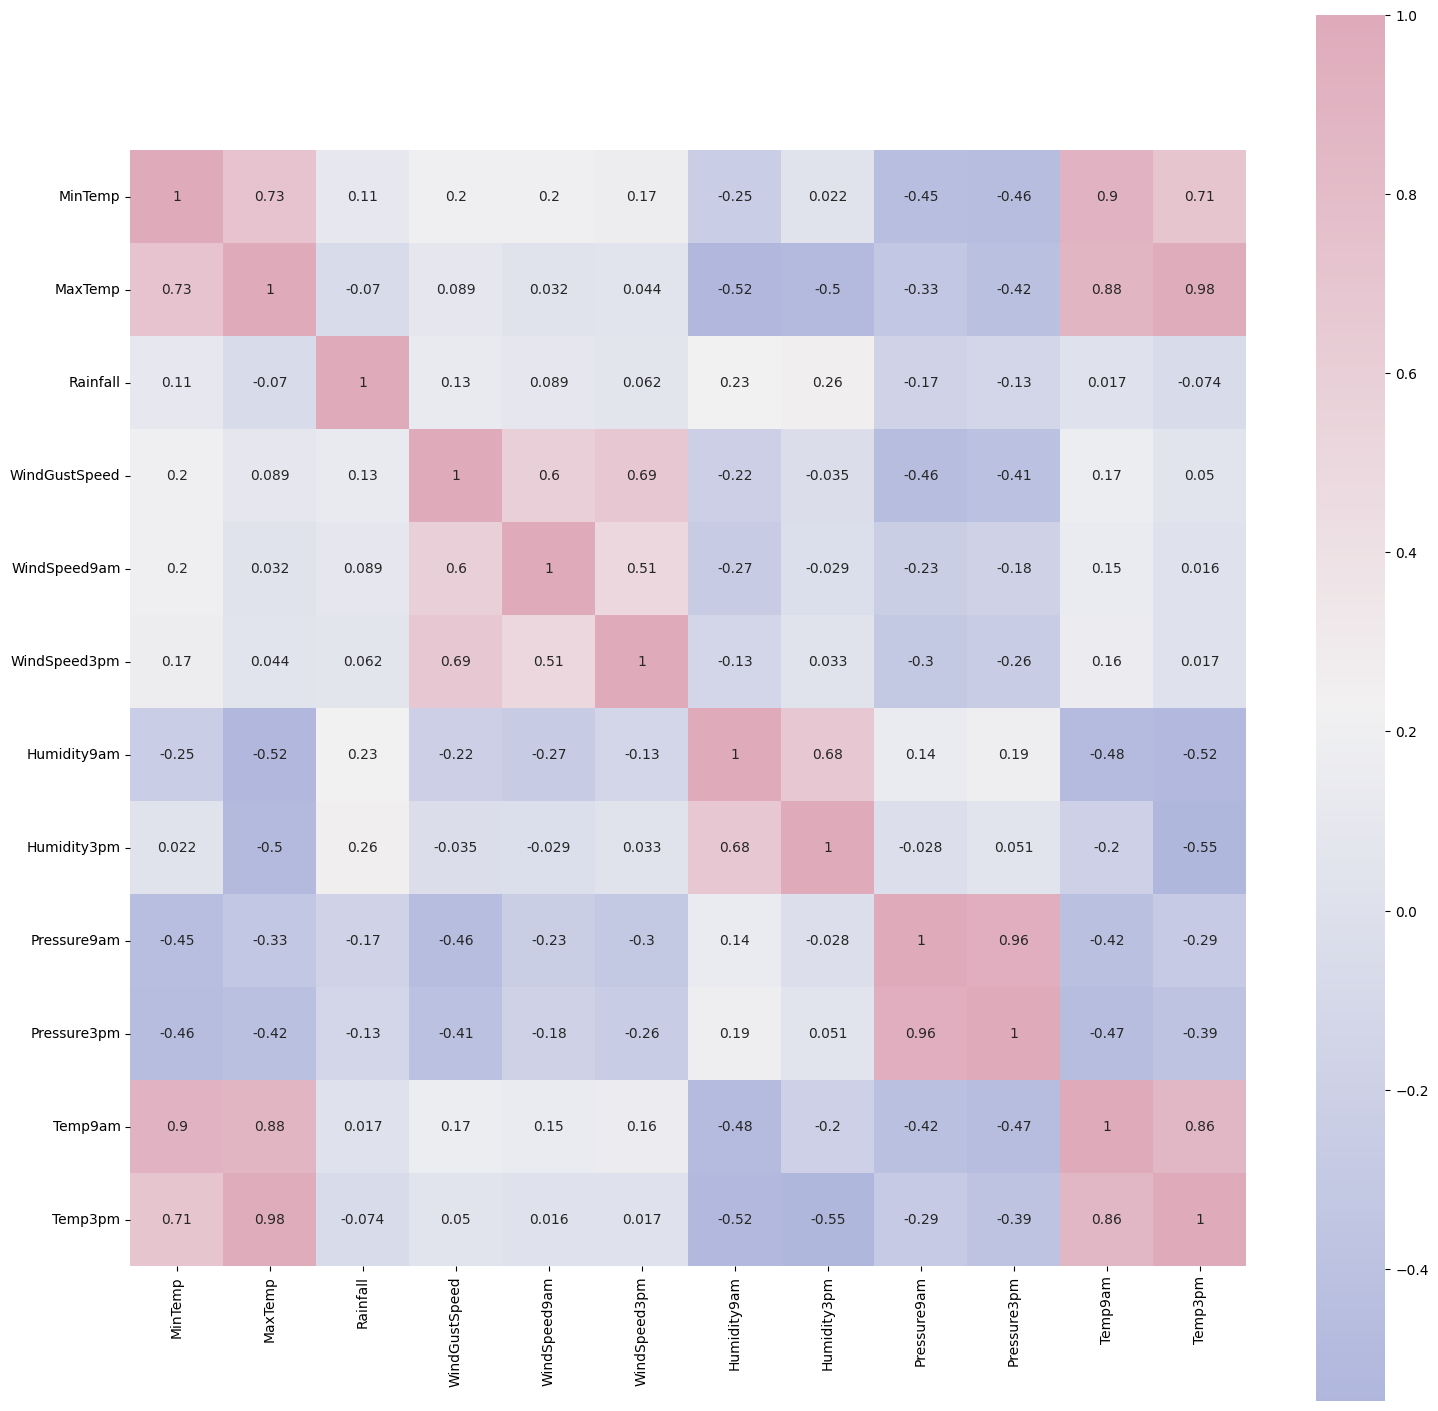

In [5]:
# Correlation amongst numeric attributes
corrmat = data.corr()
cmap = sns.diverging_palette(260, -10, s=50, l=75, n=6, as_cmap=True)
plt.subplots(figsize=(18, 18))
sns.heatmap(corrmat, cmap=cmap, annot=True, square=True)

In [6]:
#Parsing datetime
#exploring the length of date objects
lengths = data["Date"].str.len()
lengths.value_counts()

10    119590
Name: Date, dtype: int64

In [7]:
#There don't seem to be any error in dates so parsing values into datetime
data['Date'] = pd.to_datetime(data["Date"])
#Creating a collumn of year
data['year'] = data.Date.dt.year

# function to encode datetime into cyclic parameters.
#As I am planning to use this data in a neural network I prefer the months and days in a cyclic continuous feature.

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col] / max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col] / max_val)
    return data


data['month'] = data.Date.dt.month
data = encode(data, 'month', 12)

data['day'] = data.Date.dt.day
data = encode(data, 'day', 31)

data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,2008-12-01,Albury,13.4,22.9,0.6,NA,NA,W,44,W,...,21.8,No,No,2008,12,-2.449294e-16,1.0,1,0.201299,0.979530
1,2008-12-02,Albury,7.4,25.1,0.0,NA,NA,WNW,44,NNW,...,24.3,No,No,2008,12,-2.449294e-16,1.0,2,0.394356,0.918958
2,2008-12-03,Albury,12.9,25.7,0.0,NA,NA,WSW,46,W,...,23.2,No,No,2008,12,-2.449294e-16,1.0,3,0.571268,0.820763
3,2008-12-04,Albury,9.2,28.0,0.0,NA,NA,NE,24,SE,...,26.5,No,No,2008,12,-2.449294e-16,1.0,4,0.724793,0.688967
4,2008-12-05,Albury,17.5,32.3,1.0,NA,NA,W,41,ENE,...,29.7,No,No,2008,12,-2.449294e-16,1.0,5,0.848644,0.528964


Text(0.5, 0, 'Days In Year')

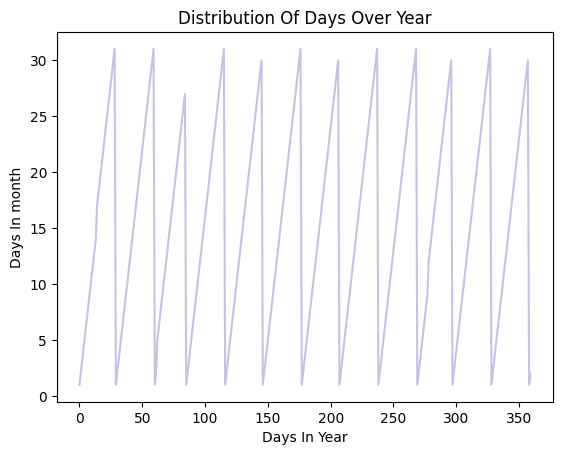

In [8]:
# roughly a year's span section
section = data[:360]
tm = section["day"].plot(color="#C2C4E2")
tm.set_title("Distribution Of Days Over Year")
tm.set_ylabel("Days In month")
tm.set_xlabel("Days In Year")

Text(0.5, 0, 'Sine Encoded Months')

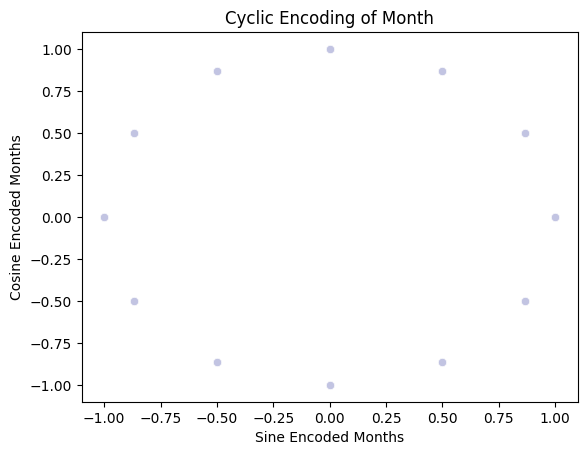

In [9]:
cyclic_month = sns.scatterplot(x="month_sin", y="month_cos", data=data, color="#C2C4E2")
cyclic_month.set_title("Cyclic Encoding of Month")
cyclic_month.set_ylabel("Cosine Encoded Months")
cyclic_month.set_xlabel("Sine Encoded Months")

Text(0.5, 0, 'Sine Encoded Day')

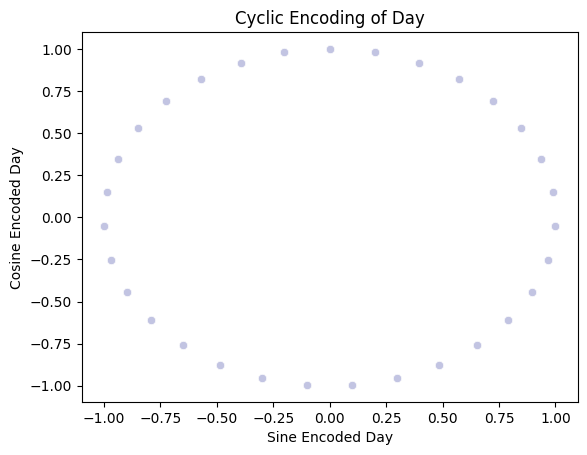

In [10]:
cyclic_day = sns.scatterplot(x='day_sin', y='day_cos', data=data, color="#C2C4E2")
cyclic_day.set_title("Cyclic Encoding of Day")
cyclic_day.set_ylabel("Cosine Encoded Day")
cyclic_day.set_xlabel("Sine Encoded Day")

In [11]:
# Get list of categorical variables
s = (data.dtypes == "object")
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Location', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'Cloud9am', 'Cloud3pm', 'RainToday', 'RainTomorrow']


In [12]:
# Missing values in categorical variables

for i in object_cols:
    print(i, data[i].isnull().sum())

Location 0
Evaporation 0
Sunshine 0
WindGustDir 0
WindDir9am 0
WindDir3pm 0
Cloud9am 0
Cloud3pm 0
RainToday 0
RainTomorrow 0


In [13]:
# Filling missing values with mode of the column in value

for i in object_cols:
    data[i].fillna(data[i].mode()[0], inplace=True)

In [14]:
# Get list of numeric variables
t = (data.dtypes == "float64")
num_cols = list(t[t].index)

print("Numeric variables:")
print(num_cols)

Numeric variables:
['MinTemp', 'MaxTemp', 'Rainfall', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'month_sin', 'month_cos', 'day_sin', 'day_cos']


In [15]:
# Missing values in numeric variables

for i in num_cols:
    print(i, data[i].isnull().sum())

MinTemp 0
MaxTemp 0
Rainfall 0
Pressure9am 0
Pressure3pm 0
Temp9am 0
Temp3pm 0
month_sin 0
month_cos 0
day_sin 0
day_cos 0


In [16]:
# Filling missing values with median of the column in value

for i in num_cols:
    data[i].fillna(data[i].median(), inplace=True)
data.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,2008-12-01,Albury,13.4,22.9,0.6,NA,NA,W,44,W,...,21.8,No,No,2008,12,-2.449294e-16,1.0,1,0.201299,0.979530
1,2008-12-02,Albury,7.4,25.1,0.0,NA,NA,WNW,44,NNW,...,24.3,No,No,2008,12,-2.449294e-16,1.0,2,0.394356,0.918958
2,2008-12-03,Albury,12.9,25.7,0.0,NA,NA,WSW,46,W,...,23.2,No,No,2008,12,-2.449294e-16,1.0,3,0.571268,0.820763
3,2008-12-04,Albury,9.2,28.0,0.0,NA,NA,NE,24,SE,...,26.5,No,No,2008,12,-2.449294e-16,1.0,4,0.724793,0.688967
4,2008-12-05,Albury,17.5,32.3,1.0,NA,NA,W,41,ENE,...,29.7,No,No,2008,12,-2.449294e-16,1.0,5,0.848644,0.528964


In [17]:
# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for i in object_cols:
    data[i] = label_encoder.fit_transform(data[i])

data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119590 entries, 0 to 119589
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           119590 non-null  datetime64[ns]
 1   Location       119590 non-null  int32         
 2   MinTemp        119590 non-null  float64       
 3   MaxTemp        119590 non-null  float64       
 4   Rainfall       119590 non-null  float64       
 5   Evaporation    119590 non-null  int32         
 6   Sunshine       119590 non-null  int32         
 7   WindGustDir    119590 non-null  int32         
 8   WindGustSpeed  119590 non-null  int64         
 9   WindDir9am     119590 non-null  int32         
 10  WindDir3pm     119590 non-null  int32         
 11  WindSpeed9am   119590 non-null  int64         
 12  WindSpeed3pm   119590 non-null  int64         
 13  Humidity9am    119590 non-null  int64         
 14  Humidity3pm    119590 non-null  int64         
 15  

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,2008-12-01,1,13.4,22.9,0.6,349,145,14,44,14,...,21.8,0,0,2008,12,-2.449294e-16,1.0,1,0.201299,0.979530
1,2008-12-02,1,7.4,25.1,0.0,349,145,15,44,7,...,24.3,0,0,2008,12,-2.449294e-16,1.0,2,0.394356,0.918958
2,2008-12-03,1,12.9,25.7,0.0,349,145,16,46,14,...,23.2,0,0,2008,12,-2.449294e-16,1.0,3,0.571268,0.820763
3,2008-12-04,1,9.2,28.0,0.0,349,145,5,24,10,...,26.5,0,0,2008,12,-2.449294e-16,1.0,4,0.724793,0.688967
4,2008-12-05,1,17.5,32.3,1.0,349,145,14,41,1,...,29.7,0,0,2008,12,-2.449294e-16,1.0,5,0.848644,0.528964


In [18]:
# Preparing attributes of scale data
featuresLR = data.drop(['Date', 'Location','day', 'month'], axis=1)
featuresLR.head(5)

features = data.drop(['RainTomorrow', 'Date', 'day', 'month'], axis=1)  # dropping target and extra columns

target = data['RainTomorrow']

#Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = preprocessing.StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names)

features.describe().T

,count,mean,std,min,25%,50%,75%,max
Location,119590.0,6.084085e-17,1.000004,-1.650786,-0.873365,-0.018202,0.836961,1.692124
MinTemp,119590.0,-4.563064e-17,1.000004,-3.233061,-0.736009,-0.045001,0.724530,3.378629
MaxTemp,119590.0,4.030707e-16,1.000004,-2.989452,-0.770904,-0.083870,0.717670,3.523060
Rainfall,119590.0,4.753192e-17,1.000004,-0.274179,-0.274179,-0.274179,-0.203300,43.151278
Evaporation,119590.0,-1.007677e-16,1.000004,-1.977341,-0.624635,0.459160,0.866602,0.866602
Sunshine,119590.0,-1.635098e-16,1.000004,-2.064135,-1.046486,0.569780,0.829181,0.829181
WindGustDir,119590.0,-1.102740e-16,1.000004,-1.685186,-1.087103,0.109064,0.906509,1.504593
WindGustSpeed,119590.0,-1.278609e-16,1.000004,-2.530298,-0.675656,-0.082171,0.585500,7.039651
WindDir9am,119590.0,-9.886639e-17,1.000004,-1.597101,-0.979023,0.051106,0.875209,1.699313
WindDir3pm,119590.0,-7.795234e-17,1.000004,-1.717770,-0.705782,0.103809,0.913399,1.520591


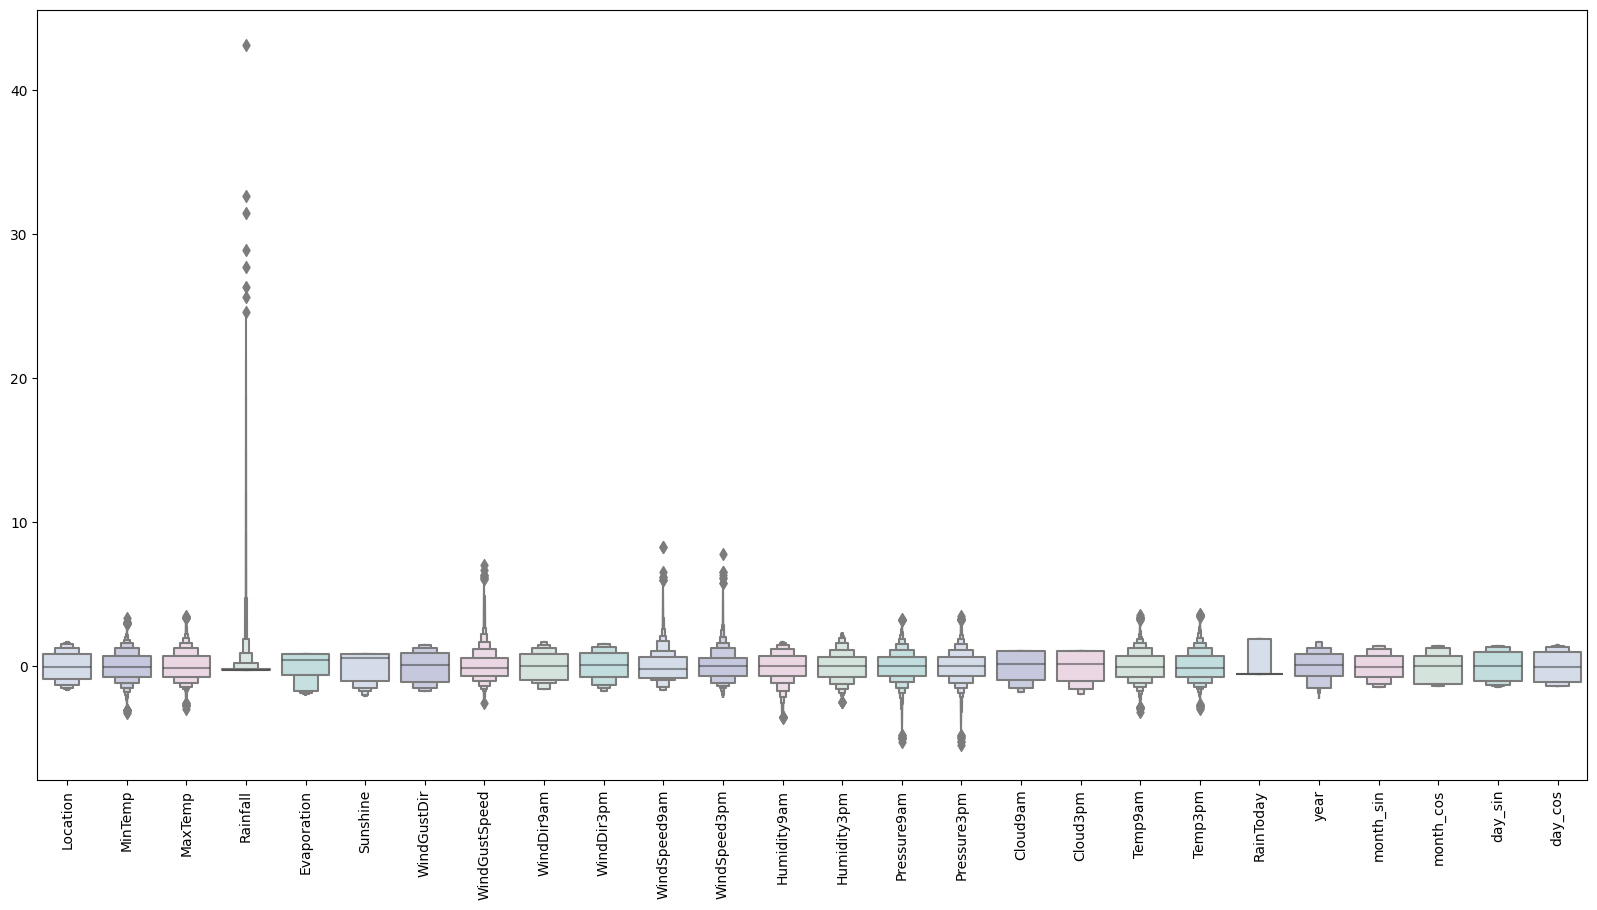

In [19]:
#Detecting outliers
#looking at the scaled features
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(20, 10))
sns.boxenplot(data=features, palette=colours)
plt.xticks(rotation=90)
plt.show()

In [20]:
#full data for
features["RainTomorrow"] = target

#Dropping with outlier

features = features[(features["MinTemp"] < 2.3) & (features["MinTemp"] > -2.3)]
features = features[(features["MaxTemp"] < 2.3) & (features["MaxTemp"] > -2)]
features = features[(features["Rainfall"] < 4.5)]
features = features[(features["Evaporation"] < 2.8)]
features = features[(features["Sunshine"] < 2.1)]
features = features[(features["WindGustSpeed"] < 4) & (features["WindGustSpeed"] > -4)]
features = features[(features["WindSpeed9am"] < 4)]
features = features[(features["WindSpeed3pm"] < 2.5)]
features = features[(features["Humidity9am"] > -3)]
features = features[(features["Humidity3pm"] > -2.2)]
features = features[(features["Pressure9am"] < 2) & (features["Pressure9am"] > -2.7)]
features = features[(features["Pressure3pm"] < 2) & (features["Pressure3pm"] > -2.7)]
features = features[(features["Cloud9am"] < 1.8)]
features = features[(features["Cloud3pm"] < 2)]
features = features[(features["Temp9am"] < 2.3) & (features["Temp9am"] > -2)]
features = features[(features["Temp3pm"] < 2.3) & (features["Temp3pm"] > -2)]

features.shape

(107630, 27)

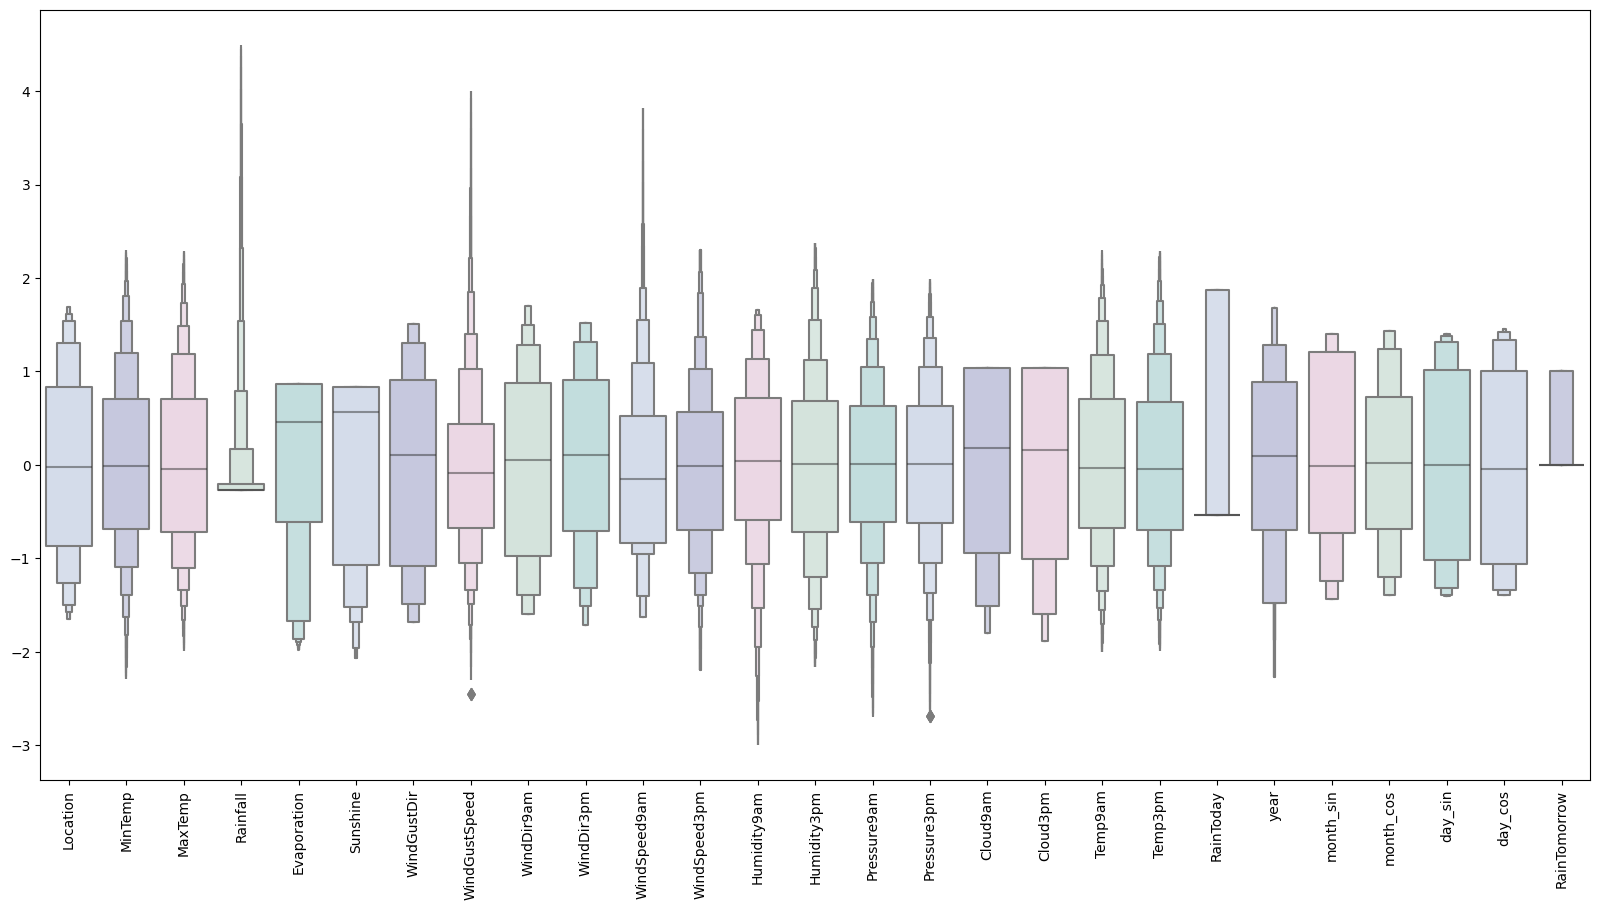

In [21]:
#looking at the scaled features without outliers
plt.figure(figsize=(20, 10))
sns.boxenplot(data=features, palette=colours)
plt.xticks(rotation=90)
plt.show()

In [22]:
database_connection = db.getConnectDataFrame()
features.to_sql(con=database_connection, name='weather_processed', if_exists='replace', index=False)

107630

In [23]:
y_LR = featuresLR.RainTomorrow.values
x_dataLR = featuresLR
x_dataLR.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,year,month_sin,month_cos,day_sin,day_cos
0,13.4,22.9,0.6,349,145,14,44,14,15,20,...,10,16.9,21.8,0,0,2008,-2.449294e-16,1.0,0.201299,0.979530
1,7.4,25.1,0.0,349,145,15,44,7,16,4,...,10,17.2,24.3,0,0,2008,-2.449294e-16,1.0,0.394356,0.918958
2,12.9,25.7,0.0,349,145,16,46,14,16,19,...,2,21.0,23.2,0,0,2008,-2.449294e-16,1.0,0.571268,0.820763
3,9.2,28.0,0.0,349,145,5,24,10,0,11,...,10,18.1,26.5,0,0,2008,-2.449294e-16,1.0,0.724793,0.688967
4,17.5,32.3,1.0,349,145,14,41,1,8,7,...,8,17.8,29.7,0,0,2008,-2.449294e-16,1.0,0.848644,0.528964


In [24]:

# In order to scale all the features between 0 and 1:
x_LR = (x_dataLR - np.min(x_dataLR)) / (np.max(x_dataLR) - np.min(x_dataLR))
x_LR.head(5)
x_LR.to_sql(con=database_connection, name='weather_processed_logistic', if_exists='replace', index=False)

119590

In [25]:
# importing sklearn's library for splitting our dataset:
from sklearn.model_selection import train_test_split
x_lR = x_LR.drop('RainTomorrow', axis=1)
x_trainLR, x_testLR, y_trainLR, y_testLR = train_test_split(x_LR, y_LR, test_size=0.2, random_state=75)

# For our matrix calculations we need to transpose our matrixis:
x_trainLR = x_trainLR.T
y_trainLR = y_trainLR.T
x_testLR = x_testLR.T
y_testLR = y_testLR.T

Cost after iteration 0: 0.726239
Cost after iteration 20: 0.194602
Cost after iteration 40: 0.110900
Cost after iteration 60: 0.076218
Cost after iteration 80: 0.057651
Cost after iteration 100: 0.046198
Cost after iteration 120: 0.038468
Cost after iteration 140: 0.032916
Cost after iteration 160: 0.028744
Cost after iteration 180: 0.025498
Cost after iteration 200: 0.022902
Cost after iteration 220: 0.020782
Cost after iteration 240: 0.019017
Cost after iteration 260: 0.017526
Cost after iteration 280: 0.016250
Cost after iteration 300: 0.015146
Cost after iteration 320: 0.014182
Cost after iteration 340: 0.013332
Cost after iteration 360: 0.012578
Cost after iteration 380: 0.011904


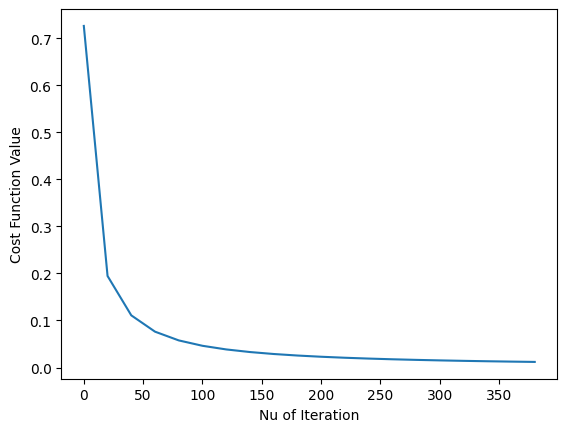

Test accuracy: 100.0%


23918

In [26]:
import model.logisticRegresstion as LR
dimension = x_trainLR.shape[0]
w, b = LR.initialize_weight_bias(dimension)    # Creating an initial weight matrix of (x_train data[0] x 1)

# Updating our w and b by using update method. 
# Update method contains our forward and backward propagation.
parameters, gradients, cost_list = LR.update(w, b, x_trainLR, y_trainLR, learning_rate=1, nu_of_iteration=400)

# Lets use x_test for predicting y:
y_test_predictions = LR.prediction(parameters['weight'], parameters['bias'], x_testLR) 

# Investigate the accuracy:
print('Test accuracy: {}%'.format(100 - np.mean(np.abs(y_test_predictions - y_testLR))*100))
result = pd.DataFrame({'id': [*range(1, y_test_predictions[0].size + 1)], 'prediction': y_test_predictions[0], 'actual': y_testLR})

result.to_sql(con=database_connection, name='result_logisticregrestion', if_exists='replace', index=False)

In [27]:
corr_data = features.corr()["RainTomorrow"].sort_values(ascending=False)
df_corr = pd.DataFrame({
    'id': [*range(1, corr_data.index.size + 1)],
    'labels': corr_data.index,
    'corr': corr_data.values})
df_corr.set_index('id')
print(df_corr)
df_corr.to_sql(con=database_connection, name='correlation', if_exists='replace', index=False)

    id         labels      corr
0    1   RainTomorrow  1.000000
1    2    Humidity3pm  0.453435
2    3      RainToday  0.294478
3    4    Humidity9am  0.269206
4    5       Rainfall  0.264366
5    6  WindGustSpeed  0.206806
6    7       Cloud3pm  0.164293
7    8       Cloud9am  0.151110
8    9        MinTemp  0.086450
9   10   WindSpeed9am  0.063437
10  11   WindSpeed3pm  0.056912
11  12    WindGustDir  0.042792
12  13     WindDir9am  0.025351
13  14     WindDir3pm  0.016407
14  15       Location  0.006181
15  16        day_cos -0.000899
16  17        day_sin -0.001142
17  18           year -0.010569
18  19      month_sin -0.023054
19  20        Temp9am -0.025784
20  21       Sunshine -0.026128
21  22    Evaporation -0.042372
22  23      month_cos -0.053897
23  24        MaxTemp -0.165297
24  25        Temp3pm -0.200424
25  26    Pressure3pm -0.207190
26  27    Pressure9am -0.224642


27

In [28]:
X = features.drop(["RainTomorrow"], axis=1)
y = features["RainTomorrow"]

# Splitting test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X.shape

(107630, 26)

In [29]:
import model.nn as nn
import numpy as np
from model.optimizer import optimizer as optimizer

X = np.array(X_train).T
Y = np.array([y_train])

# optimize using  ADAM
net = nn.nn([26, 32, 32, 1], ['relu', 'relu', 'sigmoid'], epochs=10)
net.cost_function = 'mseloss'
print('net architecture :')
print(net)

optim = optimizer.AdamOptimizer
optim(X, Y, net, alpha=0.00009, lamb=0.05, print_at=1)

net architecture :
 -> Linear(26 , 32) -> relu -> Linear(32 , 32) -> relu -> Linear(32 , 1) -> sigmoid
Epochs  1 / 10
At: 1 [==========>] Loss 0.19391736664099757  - accuracy: 0.71875
At: 2 [==========>] Loss 0.19079821136405134  - accuracy: 0.6875
At: 3 [==========>] Loss 0.15927270632717458  - accuracy: 0.78125
At: 4 [==========>] Loss 0.2249064715717659  - accuracy: 0.6875
At: 5 [==========>] Loss 0.1862593205854006  - accuracy: 0.78125
At: 6 [==========>] Loss 0.1978052328487636  - accuracy: 0.8125
At: 7 [==========>] Loss 0.19716318009536515  - accuracy: 0.65625
At: 8 [==========>] Loss 0.16223449023218092  - accuracy: 0.78125
At: 9 [==========>] Loss 0.2635827475307128  - accuracy: 0.5
At: 10 [==========>] Loss 0.18678781995460958  - accuracy: 0.6875
At: 11 [==========>] Loss 0.18362340681405487  - accuracy: 0.75
At: 12 [==========>] Loss 0.1563851811775379  - accuracy: 0.75
At: 13 [==========>] Loss 0.15023686492065152  - accuracy: 0.78125
At: 14 [==========>] Loss 0.13170846276

In [30]:
X_test = np.array(X_test).T
prediction = net.forward(X_test)
y_actual = np.array([y_test])

prediction = 1 * (prediction >= 0.5)
accuracy = np.sum(prediction == y_actual[0]) / prediction.shape[1]

print('for Adam:\n accuracy = ', accuracy * 100)

for Adam:
 accuracy =  78.79308742915543


In [31]:
prediction = net.forward(X_test)
result = pd.DataFrame({'id': [*range(1, prediction[0].size + 1)], 'prediction': prediction[0], 'actual': y_actual[0]})
result.to_sql(con=database_connection, name='result', if_exists='replace', index=False)

21526